## Cox regression

In [4]:
library(dplyr)
library(survival)
library(MASS)
library(survminer)
library(splines)

In [5]:
setwd("/Users/wilson/Desktop/Projects/Heart failure - Survival analysis")

In [7]:
df0 <- read.csv("./data/df0.csv")
level_ef_paper <- c("<=30%", "31-45%", ">45%")
level_platelets_paper <- c("<=Q1", "Q1-Q3", ">=Q3")
df0 <- df0 %>%
    mutate_at(vars(gender, smoking, diabetes, bp, anaemia), factor) %>%
    mutate(
        ef_paper = factor(ef_paper, levels = level_ef_paper, ordered = FALSE),
        platelets_paper = factor(platelets_paper, levels = level_platelets_paper, ordered = FALSE),
        platelets_paper = relevel(platelets_paper, ref = "Q1-Q3"),
        creatinine_paper = factor(creatinine_paper)
    )

In [10]:
# str(df0)

In [11]:
df1 <- read.csv("./data/df1.csv")
level_age_gp <- c("<55 years", "55-64 years", "65-74 years", ">=75 years")
level_ef_gp <- c("<40%", "40-49%", "50-74%")
level_ef_paper <- c("<=30%", "31-45%", ">45%")
level_sodium_gp <- c("<135mmol/L", "135-145mmol/L", ">145mmol/L")
level_platelets_gp <- c("Thrombocytopenia", "Normal", "Thrombocytosis")
level_platelets_paper <- c("<=Q1", "Q1-Q3", ">=Q3")

df1 <- df1 %>%
  mutate_at(vars(gender, smoking, diabetes, bp, anaemia), factor) %>%
  mutate(
    age_gp = factor(age_gp, levels = level_age_gp, ordered = FALSE),
    ef_gp = factor(ef_gp, levels = level_ef_gp, ordered = FALSE),
    ef_paper = factor(ef_paper, levels = level_ef_paper, ordered = FALSE),
    sodium_gp = factor(sodium_gp, levels = level_sodium_gp, ordered = FALSE),
    platelets_gp = factor(platelets_gp, levels = level_platelets_gp, ordered = FALSE),
    platelets_paper = factor(platelets_paper, levels = level_platelets_paper, ordered = FALSE),
    creatinine_excess = factor(creatinine_excess),
    creatinine_paper = factor(creatinine_paper),
    cpk_excess = factor(cpk_excess)
  )

In [12]:
str(df1)

'data.frame':	298 obs. of  28 variables:
 $ time                        : int  97 180 31 87 113 10 250 27 87 87 ...
 $ event                       : int  0 0 1 0 0 1 0 1 0 0 ...
 $ gender                      : Factor w/ 2 levels "0","1": 1 2 2 2 2 2 2 2 2 2 ...
 $ smoking                     : Factor w/ 2 levels "0","1": 1 2 2 1 1 1 2 1 1 2 ...
 $ diabetes                    : Factor w/ 2 levels "0","1": 1 2 1 1 1 1 1 2 1 1 ...
 $ bp                          : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 1 2 2 1 ...
 $ anaemia                     : Factor w/ 2 levels "0","1": 2 2 1 2 1 2 1 1 1 1 ...
 $ age                         : num  43 73 70 65 64 75 70 94 75 80 ...
 $ ejection.fraction           : int  50 30 20 25 60 15 40 38 45 25 ...
 $ sodium                      : int  135 142 134 141 137 137 136 134 137 144 ...
 $ creatinine                  : num  1.3 1.18 1.83 1.1 1 1.2 2.7 1.83 1.18 1.1 ...
 $ platelets                   : num  237000 160000 263358 298000 242000 ...
 $ cpk    

### Original model

#### Fitting
* Reproduce the model in the research paper ["Survival analysis of heart failure patients: A case study"](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0181001&type=printable)

In [14]:
fit <- coxph(Surv(time, event) ~ age + gender + ef_paper + smoking + diabetes + bp + creatinine_paper + sodium + log_cpk + anaemia + platelets_paper, df0)
summary(fit)

Call:
coxph(formula = Surv(time, event) ~ age + gender + ef_paper + 
    smoking + diabetes + bp + creatinine_paper + sodium + log_cpk + 
    anaemia + platelets_paper, data = df0)

  n= 299, number of events= 96 

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
age                  0.045886  1.046955  0.009543  4.808 1.52e-06 ***
gender1             -0.187928  0.828675  0.242552 -0.775 0.438461    
ef_paper31-45%      -0.971194  0.378631  0.246926 -3.933 8.38e-05 ***
ef_paper>45%        -0.769828  0.463093  0.326284 -2.359 0.018305 *  
smoking1             0.125366  1.133564  0.246430  0.509 0.610942    
diabetes1            0.199521  1.220817  0.223812  0.891 0.372679    
bp1                  0.489990  1.632300  0.216209  2.266 0.023435 *  
creatinine_paper1    0.800386  2.226400  0.237322  3.373 0.000745 ***
sodium              -0.043412  0.957516  0.023256 -1.867 0.061942 .  
log_cpk              0.098220  1.103206  0.103589  0.948 0.343043    
anaemia1       

#### Diagnosis

In [15]:
cox.zph(fit)

                    chisq df     p
age               0.00257  1 0.960
gender            0.62832  1 0.428
ef_paper          9.10854  2 0.011
smoking           1.43631  1 0.231
diabetes          0.09980  1 0.752
bp                0.13657  1 0.712
creatinine_paper  5.05686  1 0.025
sodium            0.35212  1 0.553
log_cpk           3.08190  1 0.079
anaemia           0.00541  1 0.941
platelets_paper   0.60359  2 0.739
GLOBAL           21.32736 13 0.067

* Ejection fraction has significant result, so the proportional-hazards (PH) assumption is not satisfied 

### Proposed model

#### Fitting

In [16]:
fit <- coxph(Surv(time, event) ~ normalised_age + gender + normalised_ejection.fraction + smoking + diabetes + bp + log_creatinine + sodium_gp + log_cpk + anaemia + platelets_gp, df1)
best_fit <- stepAIC(fit, direction = "both", trace=FALSE)
summary(best_fit)

Call:
coxph(formula = Surv(time, event) ~ normalised_age + normalised_ejection.fraction + 
    bp + log_creatinine + anaemia, data = df1)

  n= 298, number of events= 96 

                                 coef exp(coef) se(coef)      z Pr(>|z|)    
normalised_age                2.19941   9.01967  0.50090  4.391 1.13e-05 ***
normalised_ejection.fraction -2.92732   0.05354  0.65806 -4.448 8.65e-06 ***
bp1                           0.50830   1.66247  0.21129  2.406   0.0161 *  
log_creatinine                0.99330   2.70014  0.18927  5.248 1.54e-07 ***
anaemia1                      0.39881   1.49005  0.20824  1.915   0.0555 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                             exp(coef) exp(-coef) lower .95 upper .95
normalised_age                 9.01967     0.1109   3.37926   24.0746
normalised_ejection.fraction   0.05354    18.6776   0.01474    0.1945
bp1                            1.66247     0.6015   1.09877    2.5154
log_creatinine    

#### Diagnosis

In [17]:
cox.zph(best_fit)

                              chisq df     p
normalised_age               0.1763  1 0.675
normalised_ejection.fraction 4.7451  1 0.029
bp                           0.0237  1 0.878
log_creatinine               2.1119  1 0.146
anaemia                      0.0074  1 0.931
GLOBAL                       6.6620  5 0.247

* Ejection fraction has significant result again, so the proportional-hazards (PH) assumption is not satisfied 

### Solution 1: Categorisation

#### Fitting
* Categorise EF

In [18]:
fit <- coxph(Surv(time, event) ~ normalised_age + gender + ef_gp + smoking + diabetes + bp + log_creatinine + sodium_gp + log_cpk + anaemia + platelets_gp, df1)
best_fit <- stepAIC(fit, direction = "both", trace=FALSE)
summary(best_fit)

Call:
coxph(formula = Surv(time, event) ~ normalised_age + ef_gp + 
    bp + log_creatinine + anaemia, data = df1)

  n= 298, number of events= 96 

                  coef exp(coef) se(coef)      z Pr(>|z|)    
normalised_age  2.0828    8.0271   0.4829  4.313 1.61e-05 ***
ef_gp40-49%    -0.9265    0.3959   0.3548 -2.612  0.00901 ** 
ef_gp50-74%    -0.7180    0.4877   0.3007 -2.388  0.01695 *  
bp1             0.4848    1.6238   0.2123  2.284  0.02238 *  
log_creatinine  0.9907    2.6932   0.1776  5.577 2.45e-08 ***
anaemia1        0.3972    1.4876   0.2097  1.894  0.05825 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

               exp(coef) exp(-coef) lower .95 upper .95
normalised_age    8.0271     0.1246    3.1152   20.6836
ef_gp40-49%       0.3959     2.5257    0.1975    0.7936
ef_gp50-74%       0.4877     2.0504    0.2705    0.8793
bp1               1.6238     0.6158    1.0712    2.4617
log_creatinine    2.6932     0.3713    1.9013    3.8149
anaemia1     

#### Diagnosis

##### Check the proportional hazards assumption

In [19]:
cox.zph(best_fit)

                 chisq df    p
normalised_age 0.20310  1 0.65
ef_gp          0.67326  2 0.71
bp             0.24269  1 0.62
log_creatinine 1.68916  1 0.19
anaemia        0.00653  1 0.94
GLOBAL         2.92444  6 0.82

##### Check influential observations

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the survminer package.
  Please report the issue at <https://github.com/kassambara/survminer/issues>.”
`geom_smooth()` using formula = 'y ~ x'


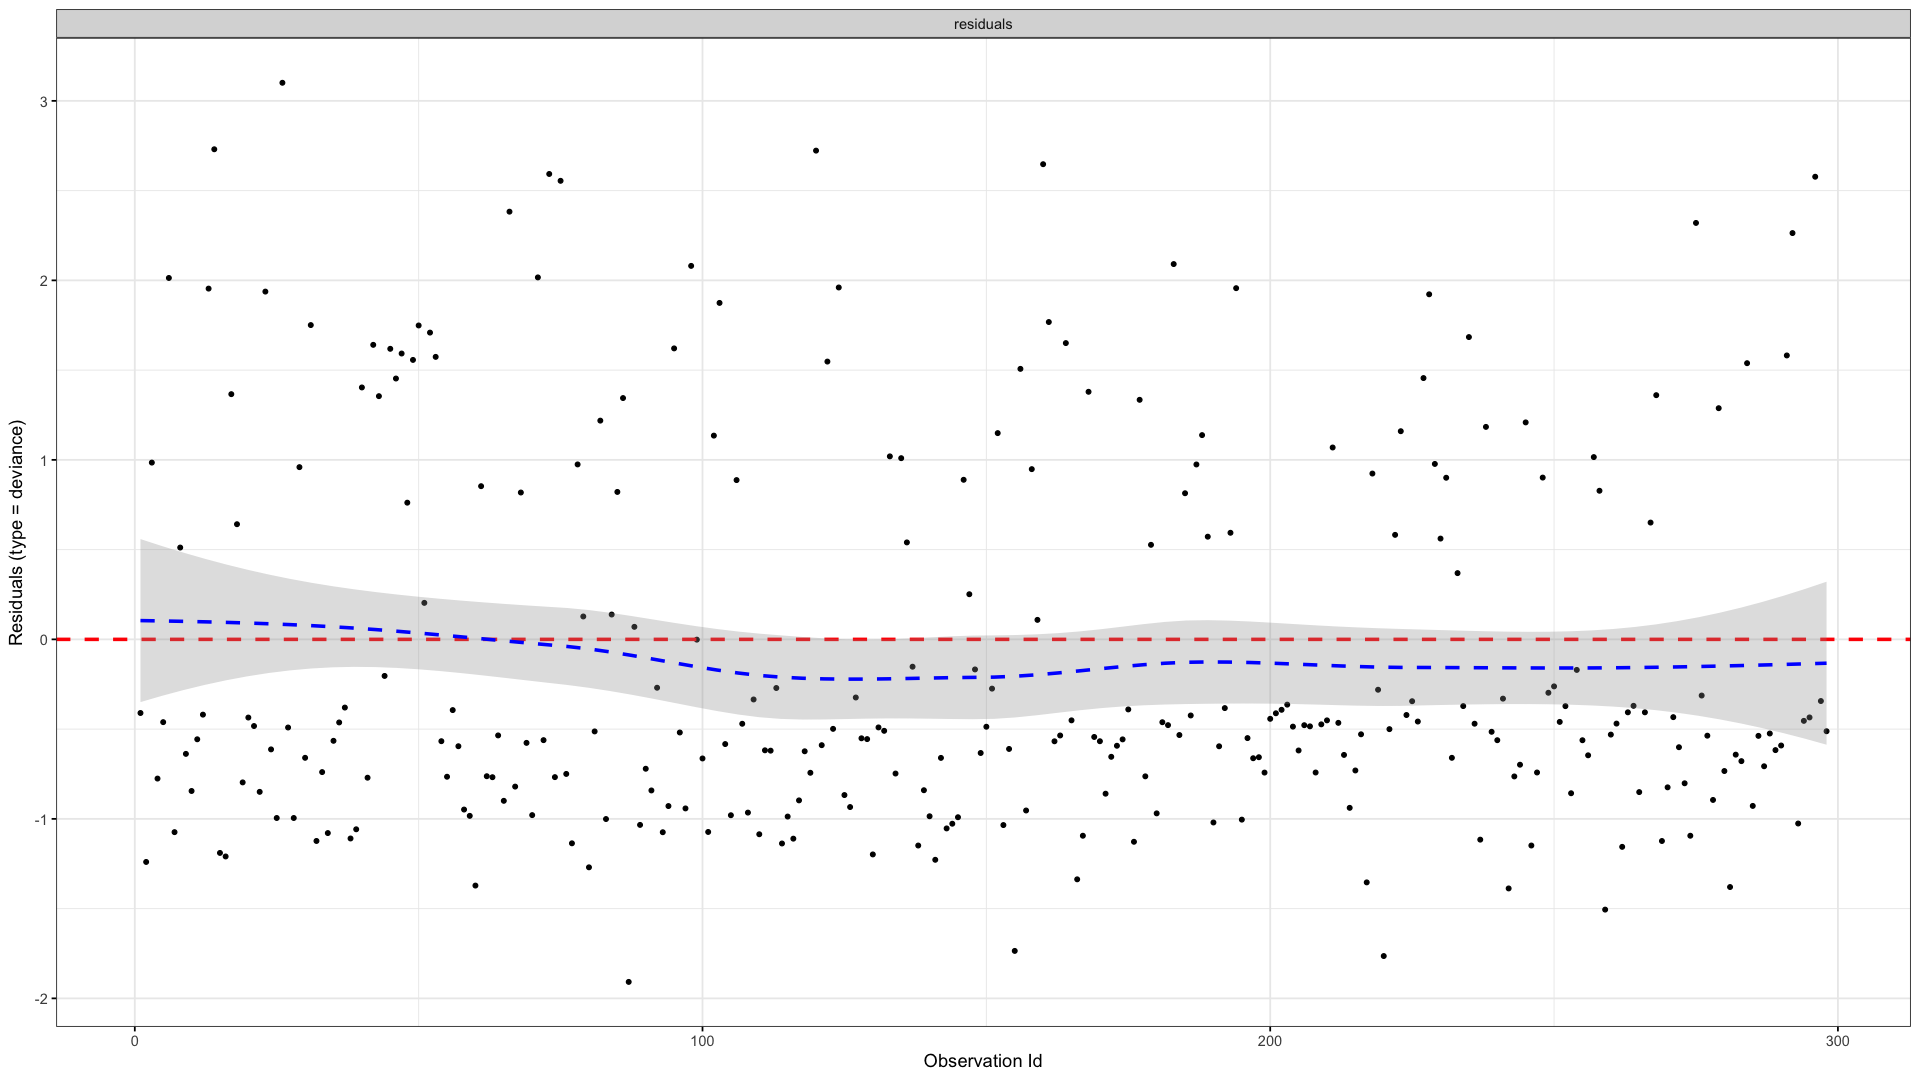

In [20]:
options(repr.plot.width=16, repr.plot.height=9)
ggcoxdiagnostics(best_fit, linear.predictions = FALSE, type = "deviance")

In [21]:
dev_resid <- residuals(best_fit, type = "deviance")
outlier_indices <- which(abs(dev_resid) > 3)
dev_resid[outlier_indices]
df1[outlier_indices, 1:13]

26 
3.100784

,time,event,gender,smoking,diabetes,bp,anaemia,age,ejection.fraction,sodium,creatinine,platelets,cpk
,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
26,6,1,1,0,0,0,0,55,38,136,1.1,263358,7861


* The smoother (blue dashed line) hovers close to zero across IDs.
* Confidence band (grey area) is narrow and steady. This suggests no major violations of model assumptions overall.
* However, there are 2 problems
    1. There may be slight asymmetry, with more points below -1 than above +1. These could suggest some mild skew in model fit.
    2. There is a point with a deviance residual > 3. Its information was further investigated. Indeed, this point is unusual. Its continuous variables such as `age` (55), `ejection.fraction` (38) and `creatinine` (1.1) have moderate values. The patient does not have neither higher blood pressure nor anaemia. However, the survival time is very short i.e. only 6 days. The mean survival time is 130 days. The reasons can be data entry error, unmeasured confounders

`geom_smooth()` using formula = 'y ~ x'


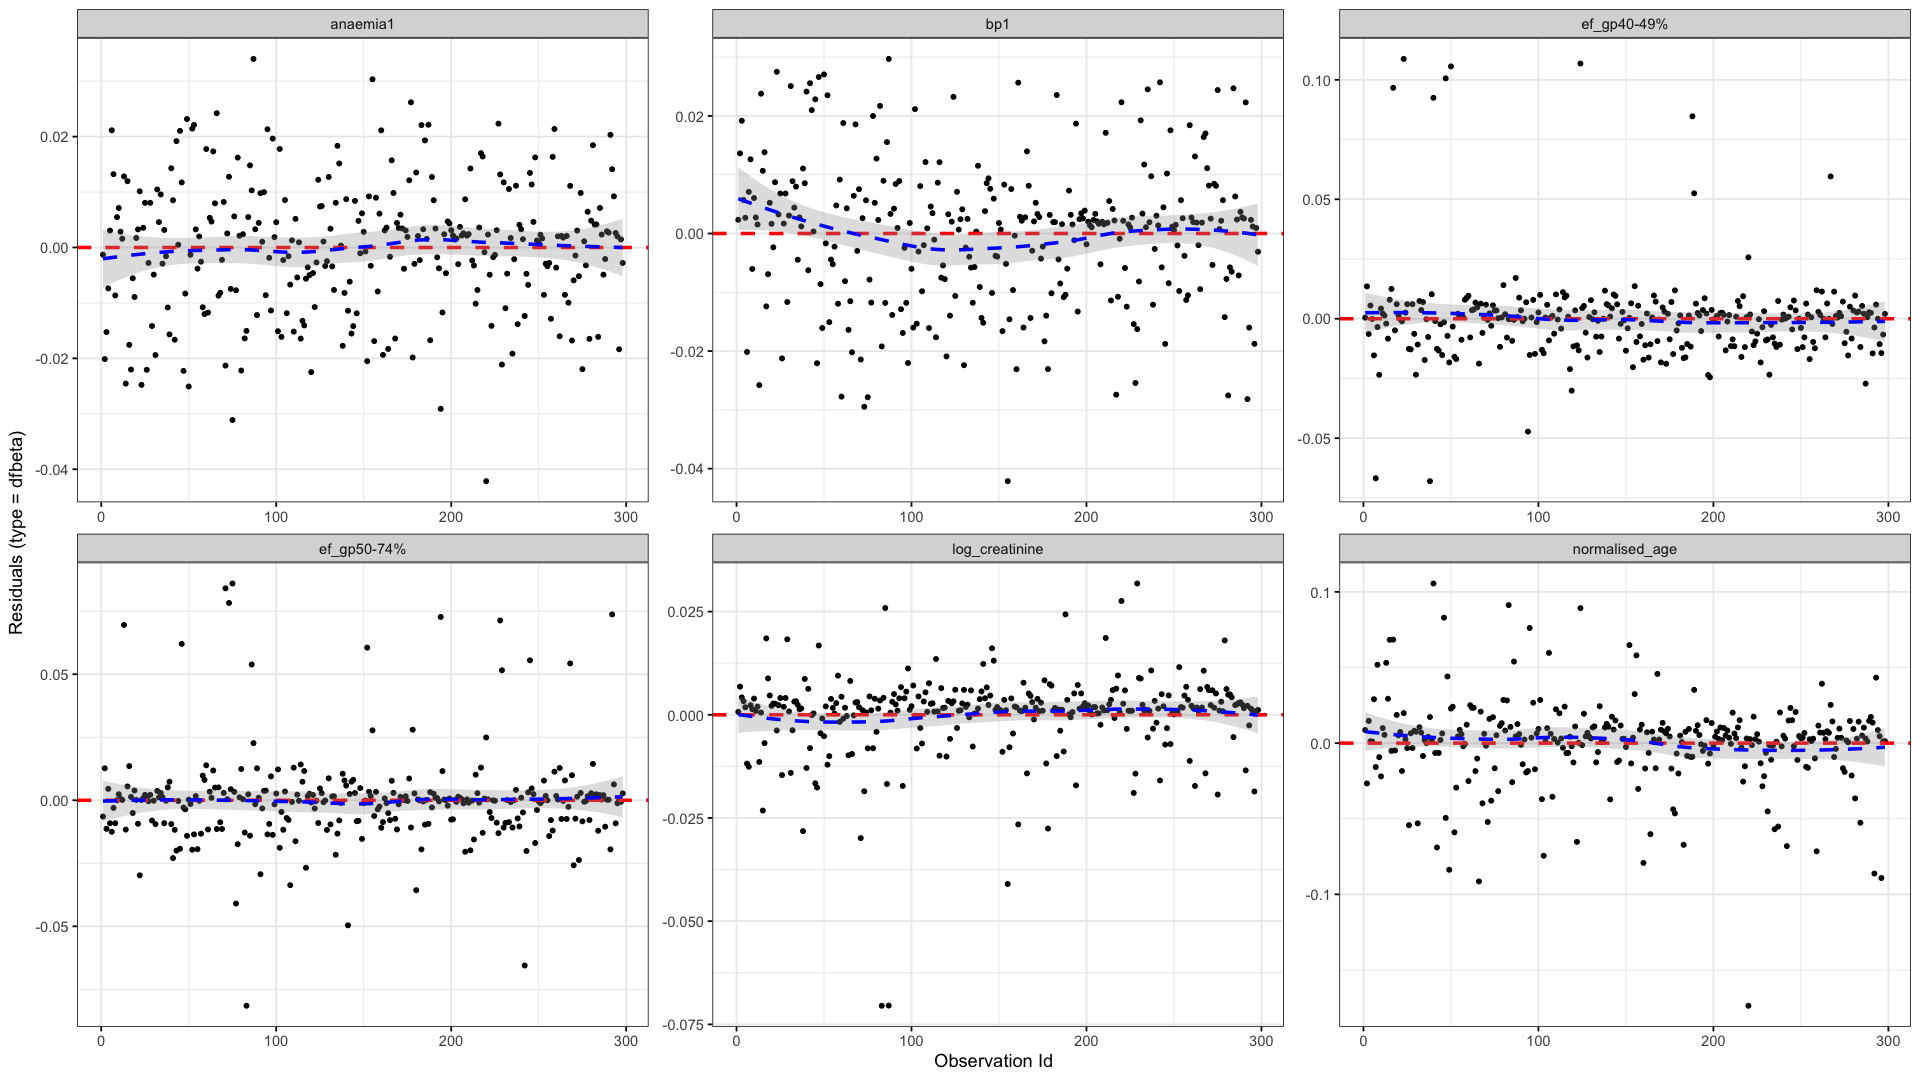

In [22]:
ggcoxdiagnostics(best_fit, type = "dfbeta")

* No extreme influential points are clearly visible for any of the covariates. All dfbeta values appear to hover around 0 with no large deviations.
* The smoothed blue lines remain fairly close to 0, indicating no systemic influence across the observation range.

##### Test non linearity

Warning message:
“arguments formula is deprecated; will be removed in the next version; please use fit instead.”


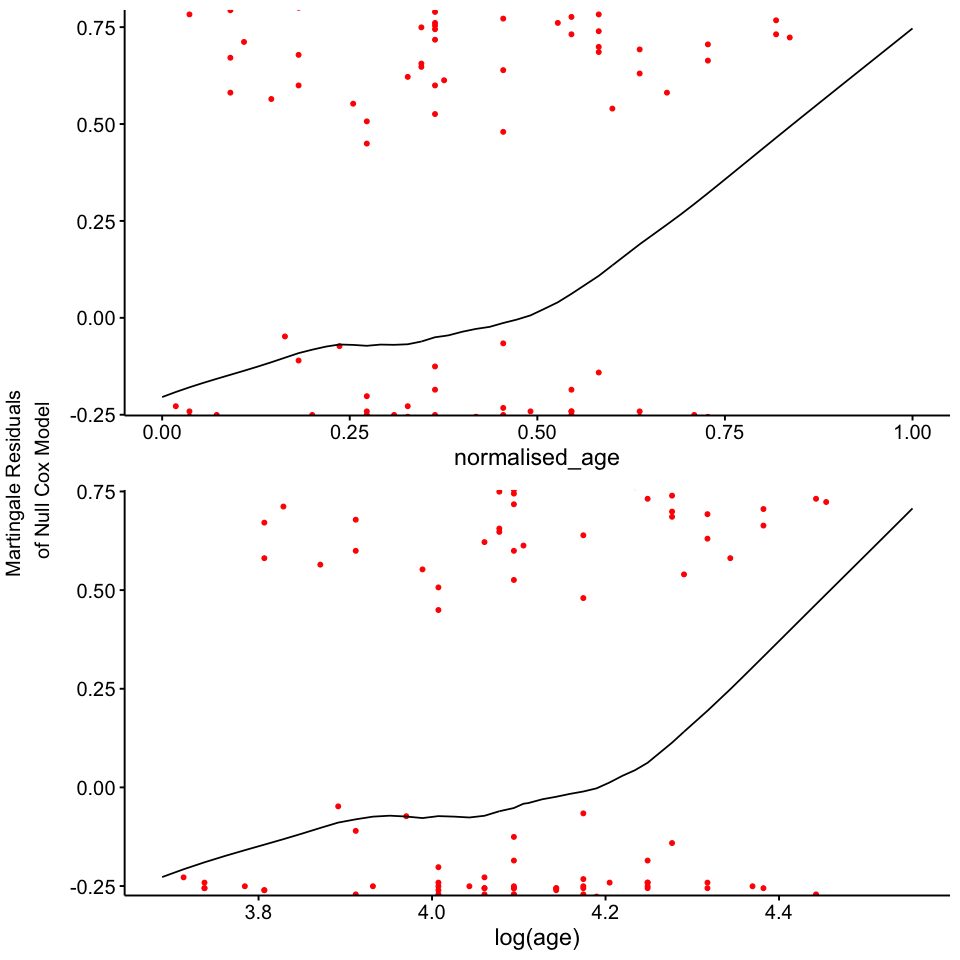

In [23]:
options(repr.plot.width=8, repr.plot.height=8)
ggcoxfunctional(Surv(time, event) ~ normalised_age + log(age), data = df1)

Warning message:
"arguments formula is deprecated; will be removed in the next version; please use fit instead."


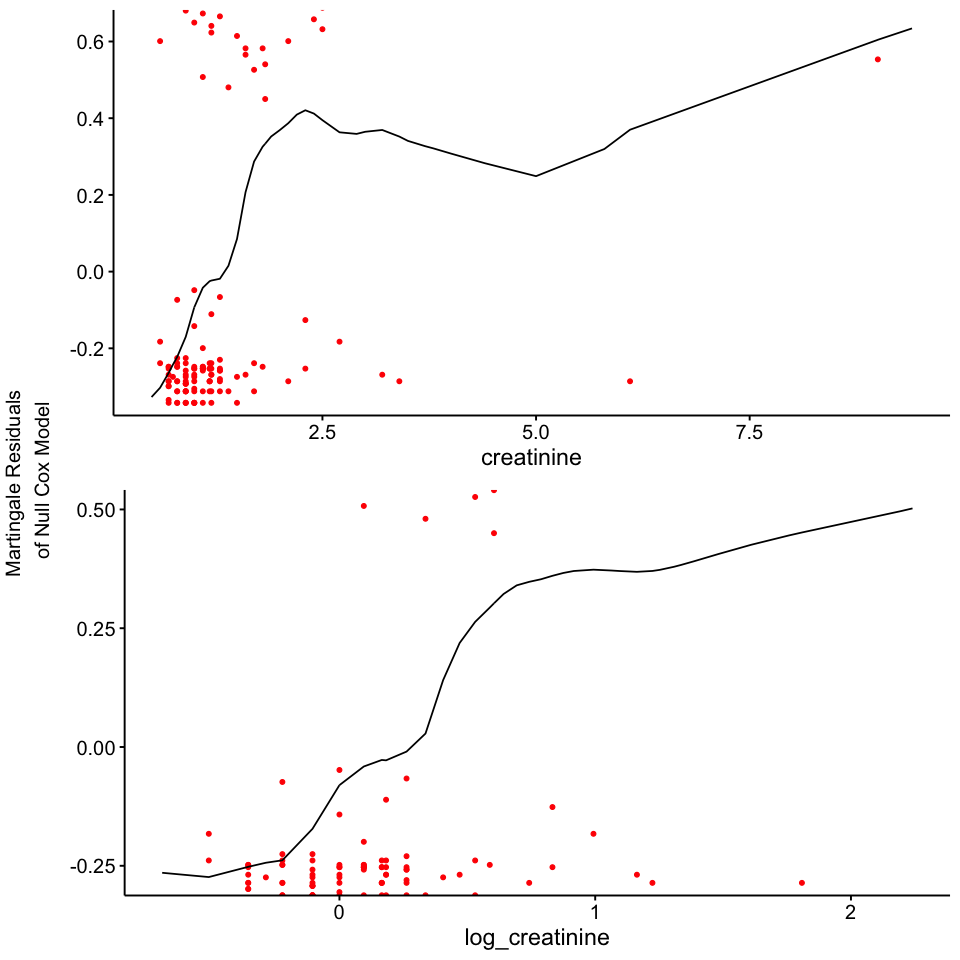

In [106]:
ggcoxfunctional(Surv(time, event) ~ creatinine + log_creatinine, data = df1)

* At the top panel (`creatinine`), the loess curve is not flat and shows a clearly non-linear pattern. This indicates that the relationship between creatinine and the log hazard may not be linear.
* At the bottom panel (`log_creatinine`), the loess curve here is much smoother and more linear compared to the raw creatinine plot. While it still isn’t perfectly flat, it is substantially more linear than the top panel.
* This suggests that `log_creatinine` is a better fit for the Cox model than `creatinine`.
* The spline model was tried

In [24]:
fit_spline <- coxph(formula = Surv(time, event) ~ normalised_age + ef_gp + 
    bp + ns(creatinine, df = 3) + sodium_gp + anaemia, data = df1)

In [25]:
anova(best_fit, fit_spline, test = "LRT")

,loglik,Chisq,Df,Pr(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-475.0162,NA,NA,NA
2,-473.2121,3.60814,4,0.4616271


* The spline model does not provide a significantly better fit than the simpler model using `log_creatinine`

#### Interpretation

* A one-unit increase in normalised age was associated with a more than eightfold increase in the hazard of the event (Hazard Ratio [HR] = 8.03, p < 0.001), indicating a strong positive association with risk.
* Participants with an ejection fraction of 40–49% exhibited a 60% reduction in hazard compared to the reference group (<40%) (HR = 0.40, p = 0.009).
* An ejection fraction of 50–74% was associated with a 51% lower hazard relative to the reference group (HR = 0.49, p = 0.017), supporting the protective effect of higher ejection fraction.
* Individuals in the elevated blood pressure group demonstrated a 62% higher hazard in comparison to the reference category (HR = 1.62, p = 0.022), suggesting increased cardiovascular risk.
* Each unit increase in the logarithm of serum creatinine was associated with a 169% increase in hazard (HR = 2.69, p < 0.001), highlighting impaired renal function as a significant risk factor.

### Reference
* Ahmad, T., Munir, A., Bhatti, S.H., Aftab, M. and Raza, M.A., 2017. _Survival analysis of heart failure patients: A case study._ PLoS ONE, 12(7), p.e0181001. https://doi.org/10.1371/journal.pone.0181001